In [59]:
import torch 
import torchinfo
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import os
import string
import Levenshtein
from time import time
from PIL import Image
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

from spellchecker import SpellChecker
from trdg.generators import GeneratorFromWikipedia

# generate synthetic data

In [51]:
generator = GeneratorFromWikipedia()

In [ ]:
for index, (img, label) in enumerate(generator):
    img.save(f'data/{label}.png')
    if index > 1000:
        break

# data

In [20]:
ascii_table = {s:i+1 for i,s in enumerate(string.printable)}
ascii_table['😀'] = 0

In [21]:
class OCR(Dataset):
    
    def __init__(self,root,transform=None):
        self.images = glob(os.path.join(root,'*.png'))
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = Image.open(self.images[idx])
        label = os.path.basename(self.images[idx]).replace('.png','')
        
        image = transforms.ToTensor()(image)
        label = torch.Tensor([ascii_table.get(s,0) for s in label]).long()
        return image, label

In [22]:
dataset = OCR('./data')

In [26]:
# dataloader = DataLoader(dataset,batch_size=1)

# model

In [23]:
class convblock(nn.Module):
    def __init__(self, in_c:int, out_c:int, k:int, s:int, p:int, bn:bool=False):
        super(convblock,self).__init__()        
        self.conv = nn.Conv2d(in_c, out_c, k, s, p)
        self.bn = nn.BatchNorm2d(out_c) if bn else bn
        self.relu = nn.ReLU(True)
            
    def forward(self,x):
        x = self.conv(x)
        if self.bn: x = self.bn(x)
        x = self.relu(x)
        
        return x

In [24]:
class recurrnetblock(nn.Module):
    def __init__(self, in_dim:int, hid_dim:int, out_dim:int):
        super(recurrnetblock,self).__init__()        
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.rnn = nn.LSTM(in_dim, hid_dim, bidirectional=True)
        self.embedding = nn.Linear(hid_dim * 2, out_dim)
            
    def forward(self,x):
        o, _ = self.rnn(x)
        t, b, h = o.shape
        o = o.view(t * b, h)
        o = self.embedding(o)
        o = o.view(t, b, self.out_dim)
        
        return o

In [25]:
class crnn(nn.Module):
    
    def __init__(self, in_dim:int, hid_dim:int, nclass:int):
        super(crnn,self).__init__()        

        self.cnn = nn.Sequential(
            convblock(3,64,3,1,1), # B, 64, H, W
            nn.MaxPool2d(2,2), # B, 64, H//2, W//2
            convblock(64,128,3,1,1), # B, 128, H//2, W//2
            nn.MaxPool2d(2,2), # B, 128, H//4, W//4
            convblock(128,256,3,1,1,True), # B, 256, H//4, W//4
            convblock(256,256,3,1,1), 
            nn.MaxPool2d((2,2), (2,1), (0,1)), # B, 256, H//8, W//4
            convblock(256,512,3,1,1,True), # B, 512, H//8, W//4
            convblock(512,512,3,1,1),
            nn.MaxPool2d((2,2), (2,1), (0,1)), # B, 512, H//16, W//4
            convblock(512,512,2,1,0,True) # B, 512, H//16-1, W//4-1
        )
        
        self.rnn = nn.Sequential(
            recurrnetblock(512, hid_dim, hid_dim),
            recurrnetblock(hid_dim, hid_dim, nclass)
        )
    
    def cnn_debug(self,x):
        for i in self.cnn:
            x = i(x)
            print(x.shape)
    
    def forward(self,x):        
        x = self.cnn(x)
        b, c, h, w = x.shape
        assert h == 1, "the height of conv must be 1"
        x = x.squeeze(2).permute(2, 0, 1) # w, b, c
        o = self.rnn(x)
        
        return o

In [9]:
torchinfo.summary(crnn(3,128,len(ascii_table)))

Layer (type:depth-idx)                   Param #
crnn                                     --
├─Sequential: 1-1                        --
│    └─convblock: 2-1                    --
│    │    └─Conv2d: 3-1                  1,792
│    │    └─ReLU: 3-2                    --
│    └─MaxPool2d: 2-2                    --
│    └─convblock: 2-3                    --
│    │    └─Conv2d: 3-3                  73,856
│    │    └─ReLU: 3-4                    --
│    └─MaxPool2d: 2-4                    --
│    └─convblock: 2-5                    --
│    │    └─Conv2d: 3-5                  295,168
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    └─convblock: 2-6                    --
│    │    └─Conv2d: 3-8                  590,080
│    │    └─ReLU: 3-9                    --
│    └─MaxPool2d: 2-7                    --
│    └─convblock: 2-8                    --
│    │    └─Conv2d: 3-10                 1,180,160
│    │    └─BatchNorm2d: 3-11            1,024

In [10]:
crnn(3,128,len(ascii_table))(torch.randn(1,3,32,1698)).shape

torch.Size([425, 1, 101])

# setting

In [26]:
device = 'cuda:0'

In [27]:
model = crnn(3,128,len(ascii_table)).to(device)

In [28]:
criterion = nn.CTCLoss(blank=ascii_table['😀'])
optim = torch.optim.Adam(model.parameters())

# training

In [29]:
epoch = 30

In [30]:
training_loss = []
for e in range(epoch):
    
    running_loss = 0
    optim.zero_grad()
    
    for data in tqdm(dataset):
        img, label = data
        img = img.unsqueeze(0).to(device)
        
        output = model(img).log_softmax(2)
        pred_len = torch.Tensor([len(output)]).long().to(device)
        trg_len = torch.Tensor([len(label)]).long().to(device)
        loss = criterion(output,label,pred_len,trg_len)
        
        loss.backward()
        
        optim.step()
        optim.zero_grad()
        
        
        running_loss += loss.item()
#         training_loss.append(ru)
        
    print(f'epoch {e+1}: ',running_loss/len(dataset))

  0%|▏                                                                                 | 2/918 [00:00<01:02, 14.64it/s]

epoch 1:  3.125126445475227


  0%|▏                                                                                 | 2/918 [00:00<01:00, 15.08it/s]

epoch 2:  2.5315221918823934


  0%|▏                                                                                 | 2/918 [00:00<01:01, 14.85it/s]

epoch 3:  1.9855604416534531


  0%|▏                                                                                 | 2/918 [00:00<01:01, 14.85it/s]

epoch 4:  1.4294446383101749


  0%|▏                                                                                 | 2/918 [00:00<01:01, 14.85it/s]

epoch 5:  1.0262338225537007


  0%|▏                                                                                 | 2/918 [00:00<01:03, 14.53it/s]

epoch 6:  0.7443176372999362


  0%|▏                                                                                 | 2/918 [00:00<01:03, 14.53it/s]

epoch 7:  0.5489569164747636


  0%|▏                                                                                 | 2/918 [00:00<01:02, 14.75it/s]

epoch 8:  0.41111228476158773


  0%|▏                                                                                 | 2/918 [00:00<01:03, 14.43it/s]

epoch 9:  0.32632873521829614


  0%|▏                                                                                 | 2/918 [00:00<01:03, 14.32it/s]

epoch 10:  0.2717337980044677


  0%|▏                                                                                 | 2/918 [00:00<01:03, 14.43it/s]

epoch 11:  0.2270297699598778


  0%|▏                                                                                 | 2/918 [00:00<01:02, 14.64it/s]

epoch 12:  0.19317978477609712


  0%|▏                                                                                 | 2/918 [00:00<01:03, 14.43it/s]

epoch 13:  0.15451798607287867


  0%|▏                                                                                 | 2/918 [00:00<01:02, 14.64it/s]

epoch 14:  0.13136563588845318


  0%|▏                                                                                 | 2/918 [00:00<01:03, 14.53it/s]

epoch 15:  0.13707988052428569


  0%|▏                                                                                 | 2/918 [00:00<01:03, 14.32it/s]

epoch 16:  0.11872751936788238


  0%|▏                                                                                 | 2/918 [00:00<01:02, 14.64it/s]

epoch 17:  0.10086941782474895


  0%|▏                                                                                 | 2/918 [00:00<01:03, 14.53it/s]

epoch 18:  0.09805365152312605


  0%|▏                                                                                 | 2/918 [00:00<01:03, 14.53it/s]

epoch 19:  0.07544749220381725


  0%|▏                                                                                 | 2/918 [00:00<01:03, 14.53it/s]

epoch 20:  0.09734940687761326


  0%|▏                                                                                 | 2/918 [00:00<01:02, 14.64it/s]

epoch 21:  0.07209924387457438


  0%|▏                                                                                 | 2/918 [00:00<01:07, 13.55it/s]

epoch 22:  0.05505466786263184


  0%|▏                                                                                 | 2/918 [00:00<01:09, 13.11it/s]

epoch 23:  0.07929186493365428


  0%|▏                                                                                 | 2/918 [00:00<01:01, 14.85it/s]

epoch 24:  0.06629613729904346


  0%|▏                                                                                 | 2/918 [00:00<01:03, 14.43it/s]

epoch 25:  0.05244064886449615


  0%|▏                                                                                 | 2/918 [00:00<01:02, 14.64it/s]

epoch 26:  0.07472635616980415


 68%|███████████████████████████████████████████████████▌                        | 623/918 [8:00:19<3:47:26, 46.26s/it]


KeyboardInterrupt: 

In [31]:
torch.save(model.state_dict(),'ocr_blank.pth')

In [20]:
model.load_state_dict(torch.load('ocr.pth'))

<All keys matched successfully>

# predict

In [32]:
def tensor2str(x:torch.Tensor, itos_table:dict)->str:
    return ''.join([itos_table.get(o.item()) for o in x])

In [36]:
def decode(output:torch.Tensor, itos_table:dict, remove_blank:bool=False, remove_repeat:bool=False)->str:
    pred_text = tensor2str(output,itos_table)
    pred_text = pred_text.strip()
    
    if remove_repeat:
        placeholder = ''
        for i, d in enumerate(pred_text):
            if i == len(pred_text)-1:
                placeholder+=d
                break
            if d!=pred_text[i+1]: placeholder+=d
        pred_text = placeholder
    
    if remove_blank:
        pred_text = pred_text.replace('😀','')

    return pred_text

In [37]:
lookup_back = {v:k for k,v in ascii_table.items()}

In [51]:
a = time()
for i, (img,label) in enumerate(dataset):
    output = model(img.unsqueeze(0).to(device))[:,0,:].max(1)[1]
    print(i+1)
    print('prediction:')
    print(decode(output,lookup_back,remove_blank=True,remove_repeat=True))
    print('label:')
    print(tensor2str(label,lookup_back))
    print('------------------------------------------------')
    
    if i > 100: break
b = time()
print('seconds for 100 examples: ',b-a)

1
prediction:
In A Bit of a Holding Pattern Uptown condo boom fades Several projects delayed as risk conscious lenders limit their exposure The Charlotte Observer March 20 2008 Retrieved December 5 2017 via NewsLi
label:
'In A Bit of a Holding Pattern Uptown condo boom fades Several projects delayed as risk conscious lenders limit their exposure The Charlotte Observer March 20 2008 Retrieved December 5 2017 via NewsLi
------------------------------------------------
2
prediction:
WNewsweek Trump Show Mirrors Reality Palm Beach Daily News February 26 2004 Retrieved November 15 2017 The latesttask is dubbed Ice Escapades as the contestants compete in the marketplace debut of T
label:
'Newsweek' Trump Show Mirrors Reality Palm Beach Daily News February 26 2004 Retrieved November 15 2017 The latest task is dubbed Ice Escapades as the contestants compete in the marketplace debut of T
------------------------------------------------
3
prediction:
Trump Force One' the plane that caries Donald

A 1910 letterpress poster advertising an auction using a variety of fonts
label:
A 1910 letterpress poster advertising an auction using a variety of fonts
------------------------------------------------
91
prediction:
a b Amico Bignami Whonamedit Ole Daniel Enersen Retrieved 2 May 2014
label:
a b Amico Bignami Whonamedit Ole Daniel Enersen Retrieved 2 May 2014
------------------------------------------------
92
prediction:
a b Beinin Joel The Palestine Communist Party 1919 1948 in MRRlP Reports No 5S Mar 1977 pp 3 17
label:
a b Beinin Joel The Palestine Communist Party 1919 1948 in MERIP Reports No 55 Mar 1977 pp 3 17
------------------------------------------------
93
prediction:
a b Biographies of Palestinian political leaders since 1967 Archived 2008 10 25 at the Wayback Machine
label:
a b Biographies of Palestinian political leaders since 1967 Archived 2008 10 25 at the Wayback Machine
------------------------------------------------
94
prediction:
a a e Palestinian Political Part

write
Trump Force One' the plane that caries Donald Trump from campaign stop to campaign stop KTAR com KTAR com August 2 2015 Retrieved April 22 2016
Ks present name originales trom he frankish term Dustrick y Easlen Kingdom least of the Frankish Hingdomy
PPlrueingainleta


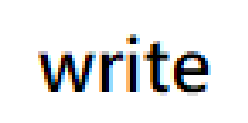

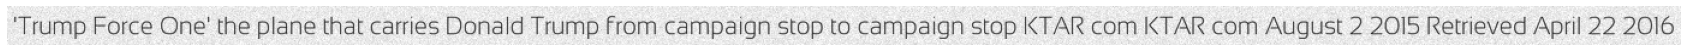

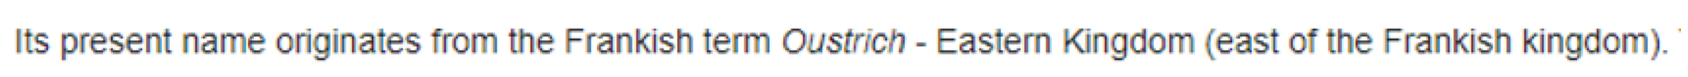

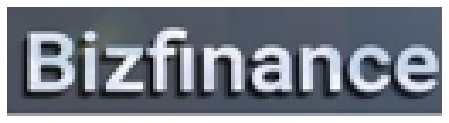

In [87]:
demo_list = [
    ('mspaint','./write.png'),
    ('synthetic',"""./data/'Trump Force One' the plane that carries Donald Trump from campaign stop to campaign stop KTAR com KTAR com August 2 2015 Retrieved April 22 2016.png"""),
    ('wiki','./wiki.png'),
    ('internet','./signboard.jpg'),
]

# plt.figure(figsize=(30,8))
for i, (source,name) in enumerate(demo_list):
    demo_pic = Image.open(name).convert('RGB')
    w,h = demo_pic.size
    demo_pic = demo_pic.resize((int(w*32/h),32))
    demo_text = transforms.ToTensor()(demo_pic).unsqueeze(0).to(device)
    decoded = decode(model(demo_text)[:,0,:].max(1)[1],lookup_back,remove_blank=True,remove_repeat=True)
    
    plt.figure(figsize=(30,2))  
#     plt.title(source)
    plt.axis('off')
    plt.imshow(demo_pic)
    print(decoded)

In [53]:
# bad, even english
spell = SpellChecker()
misspelled = spell.unknown(['caries'])
for m in misspelled:
    print(spell.correction(m))

In [71]:
import neuspell
from neuspell import BertChecker

data folder is set to `C:\Users\User\AppData\Roaming\Python\Python38\site-packages\neuspell\../data` script


In [ ]:
checker = BertChecker()
checker.from_pretrained()

In [ ]:
checker.correct("I luk foward to receving your reply")

# evaluation

In [44]:
score = 0

for img,label in tqdm(dataset):
    output = model(img.unsqueeze(0).to(device))[:,0,:].max(1)[1]
    dist = Levenshtein.distance(decode(output,lookup_back,remove_blank=True,remove_repeat=True),tensor2str(label,lookup_back))
    score += dist

100%|████████████████████████████████████████████████████████████████████████████████| 918/918 [00:13<00:00, 67.08it/s]


In [45]:
score/len(dataset)

1.5740740740740742